### Applying linear models generated using SynDNAs to calculate absolute abundance

In [2]:
library(tidyverse)
library(data.table)
library(reshape2)
library(ggplot2)
library(RColorBrewer)
library(vegan)
library(plyr)
library(dplyr) 
library(ggpubr)
library(Hmisc)
library(corrplot)
library(ggpmisc)
library(scales)
library(broom)
library(FactoMineR)
library(factoextra)

#### Loading metadata, models, flow data and frequency table

In [33]:
linearmodels <- read.delim("data/saliva_linear_models.tsv", h=T)
flowcounts <- read.delim("data/Saliva_Flow_data.tsv", head=T)
metadata <- read.delim("data/synDNA_metadata_updated.tsv", h=T)
freqtable <- fread("data/HMP_frequency_table.tsv", head=T)
freqtable <- as.data.frame(freqtable)

metadatagenomes <- fread("data/taxaID_length_fulllineage.tsv", sep = "\t", h=T)
metadatagenomes <- as.data.frame(metadatagenomes)

#### Calculation raw counts by Species

In [14]:
dfRawSpecies <- NULL
dfsum <- ddply(freqtable,.(OTUID),colwise(sum))

for(i in 2:dim(dfsum)[2]){
    df <- data.frame(OTUID = dfsum$OTUID, RawCounts = dfsum[,i])
    SampleIDs <- colnames(dfsum)

    metaspecies <- data.frame(OTUID = metadatagenomes$GenomeID, 
                              Species = metadatagenomes$species, 
                              Length = metadatagenomes$Length)

    metaspecies <- merge(df, metaspecies, by = "OTUID")
    metaspecies <- metaspecies[which(metaspecies$RawCounts != 0),]
    dfaggreg <- aggregate(metaspecies$RawCounts, by=list(metaspecies$Species), FUN=sum)
    colnames(dfaggreg) <- c("Species", "RawCounts")
    dfout <- data.frame(SampleID = SampleIDs[i], AlignedReads = sum(dfaggreg$RawCounts), dfaggreg)
    dfRawSpecies <- rbind(dfRawSpecies, dfout)
}

In [15]:
## Genome length (average) and coverage

len <- NULL
Tol <- NULL
for(i in 1:dim(dfRawSpecies)[1]){
    len <- c(len, mean(metadatagenomes$Length[which(metadatagenomes$species == dfRawSpecies$Species[i])]))
    Tol <- c(Tol, metadata$TotalReads[which(metadata$ID == dfRawSpecies$SampleID[i])])
}

dfRawSpecies$GenomeLenght <- len
dfRawSpecies$TotalReads <- Tol
dfRawSpecies$Cov <- (dfRawSpecies$RawCounts*150)/dfRawSpecies$GenomeLenght

#### Applying the linear models to sequencing data

In [16]:
##Removing rare/low abundante species

dfCovSel <- dfRawSpecies[which(dfRawSpecies$Cov >= 1),]

##Applying the linear models

dfall <- NULL

for(i in 1:dim(linearmodels)[1]){
    df <- dfCovSel[dfCovSel$SampleID %in% linearmodels$ID[i],]
    df$Relab <- ((df$RawCounts)/sum(df$RawCounts))*100 

    df$Norm <- log10((df$RawCounts/sum(df$RawCounts))*1000000) ##Because we used log10 values to build the model
    reads2weigth <- linearmodels$a_intercept[i] + (linearmodels$b_slope[i]*df$Norm)
    reads2weigth <- 10^(-reads2weigth) ## counts were in log scale.
    GenomeSize <- df$GenomeLenght
    df$CellNumber <- (reads2weigth * (6.022*(10^23))) / (GenomeSize * (1*(10^9)) * 650)
    df$Predicted <- (df$CellNumber/sum(df$CellNumber))*100

    df <- df[order(df$Predicted, decreasing = TRUE), ]
    df$FC_cells_per_ul_r1 <- flowcounts$FC_cells_per_ul_r1[which(flowcounts$SampleID == gsub("_.*", "", df$SampleID)[1])]
    df$CellFlow <- (df$RawCounts/df$GenomeLenght)/df$FC_cells_per_ul_r1
    df$PercFlow <- (df$CellFlow/(sum(df$CellFlow)))*100
 
    dfall <- rbind(dfall, df)
}


In [22]:
## Select strand and pool

dfallmeta <- merge(metadata, dfall, by.x = "ID", by.y = "SampleID")
dfallmeta <- dfallmeta[grep("forward", dfallmeta$Strand), ]
dfallmeta <- dfallmeta[grep("pool2", dfallmeta$Pool), ]
dfallmeta <- dfallmeta[-grep("Prevotella melaninogenica", dfallmeta$Species), ]

#### Correlation analysis: SynDNA Predicted vs. Flow Cytometer

In [23]:
## Using TidyVerse to calculate Pearson Correlation between methods
# Predicted vs. Flow cytometer

analysis <- dfallmeta %>%
  group_by(Sample) %>%
  nest() %>%
  mutate(model = map(data, ~lm(Predicted ~ PercFlow, data = .)),
    cor = map(data, ~tidy(cor.test(.x$Predicted, .x$PercFlow, method = "pearson"), 3)))

stats <- analysis %>%
  unnest(cor)


## Plotting correlation graphs

options(repr.plot.width=15, repr.plot.height=3)

conditiongroup <- c("A1", "C1", "D1", "E1", "F1", "H1")

dfallmeta$Sample <- factor(dfallmeta$Sample,
                                    levels = conditiongroup, ordered = TRUE)

p1 <- ggplot(dfallmeta, aes(Predicted, PercFlow)) +
    geom_point(shape = 20, size = 4) +
    facet_wrap(~ Sample, ncol = 6) +
    geom_smooth(method = "lm", color="black", se = TRUE, formula = y ~ x) +
    geom_text(data = stats, aes(label = sprintf("r = %s", round(estimate, 3)), x = 9, y = 43), size=5) +
    geom_text(data = stats, aes(label = sprintf("p = %s", round(p.value, 3)),  x = 9, y = 37), size=5) +
    labs(x = "Predicted synDNA (%)", y = "Flow Cytometer (%)") +
    #coord_cartesian(ylim = c(-2, 20), xlim = c(-10, 12)) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    theme_bw() + guides(fill=guide_legend(ncol=1))  +
    theme(axis.text.x=element_text(angle = 0, size = 16, colour = "black"),
        axis.text.y = element_text(angle = 0, size = 16, colour = "black"),
        axis.text = element_text(size = 16, colour = "black"),
        axis.title=element_text(size=16, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 16, face = "bold", colour = "black"),
        strip.background = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"),
        legend.position="bottom", legend.box="vertical", legend.margin=margin(), 
        legend.title=element_blank(),
        legend.text=element_text(size=16))

#### Correlation analysis: SynDNA Predicted vs. Relative abundance

In [24]:
## Using TidyVerse to calculate Pearson Correlation between methods
# Predicted vs. Relative abundance


analysis <- dfallmeta %>%
  group_by(Sample) %>%
  nest() %>%
  mutate(model = map(data, ~lm(Predicted ~ Relab, data = .)),
    cor = map(data, ~tidy(cor.test(.x$Predicted, .x$Relab, method = "pearson"), 3)))

stats <- analysis %>%
  unnest(cor)


## Plotting correlation graphs

options(repr.plot.width=15, repr.plot.height=3)

conditiongroup <- c("A1", "C1", "D1", "E1", "F1", "H1")

dfallmeta$Sample <- factor(dfallmeta$Sample,
                                    levels = conditiongroup, ordered = TRUE)

p2 <- ggplot(dfallmeta, aes(Predicted, Relab)) +
    geom_point(shape = 20, size = 4) +
    facet_wrap(~ Sample, ncol = 6) +
    geom_smooth(method = "lm", color="black", se = TRUE, formula = y ~ x) +
    geom_text(data = stats, aes(label = sprintf("r = %s", round(estimate, 3)), x = 9, y = 43), size=5) +
    geom_text(data = stats, aes(label = sprintf("p = %s", round(p.value, 3)),  x = 9, y = 37), size=5) +
    labs(x = "Predicted synDNA (%)", y = "Relative abundance (%)") +
    #coord_cartesian(ylim = c(-2, 20), xlim = c(-10, 12)) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    theme_bw() + guides(fill=guide_legend(ncol=1))  +
    theme(axis.text.x=element_text(angle = 0, size = 16, colour = "black"),
        axis.text.y = element_text(angle = 0, size = 16, colour = "black"),
        axis.text = element_text(size = 16, colour = "black"),
        axis.title=element_text(size=16, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 16, face = "bold", colour = "black"),
        strip.background = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"),
        legend.position="bottom", legend.box="vertical", legend.margin=margin(), 
        legend.title=element_blank(),
        legend.text=element_text(size=16))

#### Correlation analysis: Relative abundance vs. Flow cytometer

In [25]:
## Using TidyVerse to calculate Pearson Correlation between methods
# Relative abundance vs. Flow cytometer


analysis <- dfallmeta %>%
  group_by(Sample) %>%
  nest() %>%
  mutate(model = map(data, ~lm(PercFlow ~ Relab, data = .)),
    cor = map(data, ~tidy(cor.test(.x$PercFlow, .x$Relab, method = "pearson"), 3)))

stats <- analysis %>%
  unnest(cor)


## Generating correlation graphs

options(repr.plot.width=15, repr.plot.height=3)

conditiongroup <- c("A1", "C1", "D1", "E1", "F1", "H1")

dfallmeta$Sample <- factor(dfallmeta$Sample,
                                    levels = conditiongroup, ordered = TRUE)

p3 <- ggplot(dfallmeta, aes(PercFlow, Relab)) +
    geom_point(shape = 20, size = 4) +
    facet_wrap(~ Sample, ncol = 6) +
    geom_smooth(method = "lm", color="black", se = TRUE, formula = y ~ x) +
    geom_text(data = stats, aes(label = sprintf("r = %s", round(estimate, 3)), x = 9, y = 43), size=5) +
    geom_text(data = stats, aes(label = sprintf("p = %s", round(p.value, 3)),  x = 9, y = 37), size=5) +
    labs(x = "Flow Cytometer (%)", y = "Relative abundance (%)") +
    #coord_cartesian(ylim = c(-2, 20), xlim = c(-10, 12)) +
    guides(colour = guide_legend(override.aes = list(size=5))) +
    theme_bw() + guides(fill=guide_legend(ncol=1))  +
    theme(axis.text.x=element_text(angle = 0, size = 16, colour = "black"),
        axis.text.y = element_text(angle = 0, size = 16, colour = "black"),
        axis.text = element_text(size = 16, colour = "black"),
        axis.title=element_text(size=16, face = "bold", colour = "black"),
        strip.text.x = element_text(size = 16, face = "bold", colour = "black"),
        strip.background = element_blank(),
        panel.background = element_blank(),
        panel.border = element_rect(colour = "black"),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(colour = "black"),
        legend.position="bottom", legend.box="vertical", legend.margin=margin(), 
        legend.title=element_blank(),
        legend.text=element_text(size=16))

#### Plotting correlation graphs

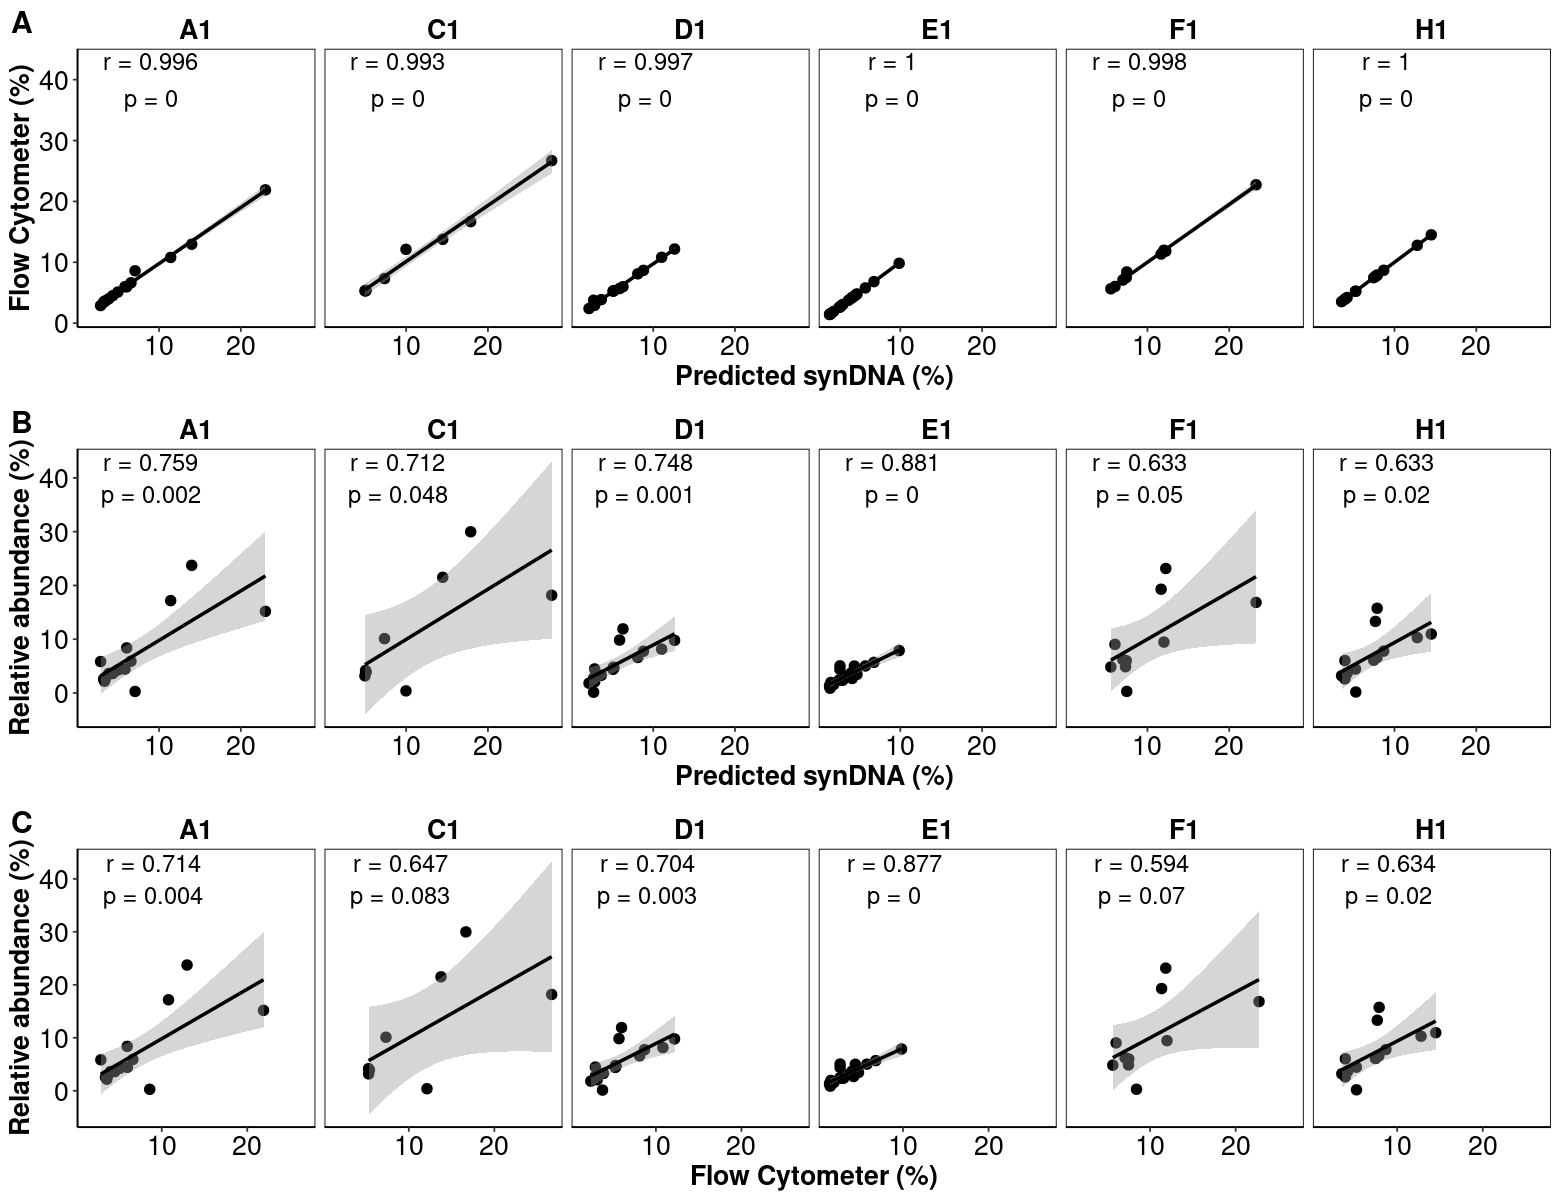

In [26]:
options(repr.plot.width=13, repr.plot.height=10)

#svg("correlation_analysis.svg", width = 15, height = 10)

ggarrange(p1, p2, p3,
          labels = c("A", "B", "C"),
          font.label = list(size = 18),
          ncol = 1, nrow = 3)

#dev.off()

#### Clustering analysis

In [27]:
dfCovSel <- dfRawSpecies[which(dfRawSpecies$Cov >= 0),]

dfall <- NULL

for(i in 1:dim(linearmodels)[1]){
    df <- dfCovSel[dfCovSel$SampleID %in% linearmodels$ID[i],]
    df$Relab <- ((df$RawCounts)/sum(df$RawCounts))*100 

    df$Norm <- log10((df$RawCounts/sum(df$RawCounts))*1000000) ##Because I used log10 values to build the model
    reads2weigth <- linearmodels$a_intercept[i] + (linearmodels$b_slope[i]*df$Norm)
    reads2weigth <- 10^(-reads2weigth)
    GenomeSize <- df$GenomeLenght
    df$CellNumber <- (reads2weigth * (6.022*(10^23))) / (GenomeSize * (1*(10^9)) * 650)
    df$Predicted <- (df$CellNumber/sum(df$CellNumber))*100

    df <- df[order(df$Predicted, decreasing = TRUE), ]
    df$FC_cells_per_ul_r1 <- flowcounts$FC_cells_per_ul_r1[which(flowcounts$SampleID == gsub("_.*", "", df$SampleID)[1])]
    df$CellFlow <- (df$RawCounts/df$GenomeLenght)/df$FC_cells_per_ul_r1
    df$PercFlow <- (df$CellFlow/(sum(df$CellFlow)))*100
 
    dfall <- rbind(dfall, df)
}


In [28]:
## Creating percentage matrix

RelabMatrix <- dcast(data = dfall, formula = SampleID~Species, value.var = "Relab")
RelabMatrix[is.na(RelabMatrix)] <- 0
rownames(RelabMatrix) <- RelabMatrix[,1]
dfN <- data.frame(Participant = gsub("_.*", "", rownames(RelabMatrix)), 
                  Method = rep("Relative Abundance", dim(RelabMatrix)[1]))
RelabMatrix <- cbind(dfN, RelabMatrix)

PredictedMatrix <- dcast(data = dfall, formula = SampleID~Species, value.var = "Predicted")
PredictedMatrix[is.na(PredictedMatrix)] <- 0
rownames(PredictedMatrix) <- PredictedMatrix[,1]
dfN <- data.frame(Participant = gsub("_.*", "", rownames(PredictedMatrix)), 
                  Method = rep("SynDNA", dim(PredictedMatrix)[1]))
PredictedMatrix <- cbind(dfN, PredictedMatrix)

FlowMatrix <- dcast(data = dfall, formula = SampleID~Species, value.var = "PercFlow")
FlowMatrix[is.na(FlowMatrix)] <- 0
rownames(FlowMatrix) <- FlowMatrix[,1]
dfN <- data.frame(Participant = gsub("_.*", "", rownames(FlowMatrix)), 
                  Method = rep("Flow Cytometer", dim(FlowMatrix)[1]))
FlowMatrix <- cbind(dfN, FlowMatrix)

In [29]:
allMatrix <- rbind(RelabMatrix, PredictedMatrix, FlowMatrix)
logallMatrix <- log(allMatrix[,-c(1,2,3)]+1) # zeros are not allowed
pca <- PCA(logallMatrix, scale = FALSE)

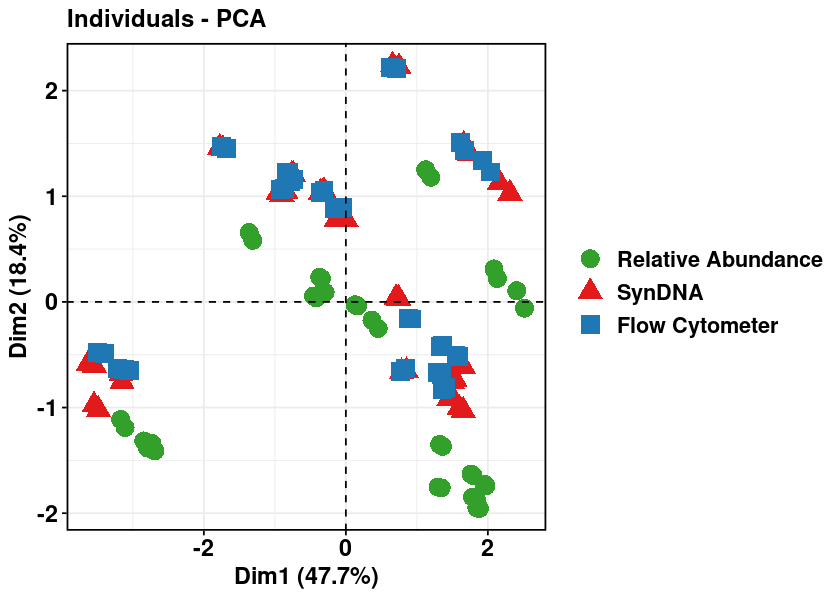

In [30]:
options(repr.plot.width=7, repr.plot.height=5)

fviz_pca_ind(pca,habillage=allMatrix$Method, geom="point", repel = TRUE, labelsize = 3, pointsize = 5,
             palette = c("#33a02c", "#e31a1c", "#1f78b4"), invisible="quali") +
     theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
            text = element_text(size = 12, face = "bold", colour = "black"),
            axis.title = element_text(size = 14, face = "bold", colour = "black"),
            axis.text = element_text(size = 14, face = "bold", colour = "black"),
            #legend.position="bottom", legend.box="vertical", legend.margin=margin(), 
            legend.title=element_blank(),
            legend.key.size = unit(0.7, 'cm'),
            legend.text=element_text(size=13, face = "bold", colour = "black")) +
            guides(color = guide_legend(override.aes = list(size = 5)))


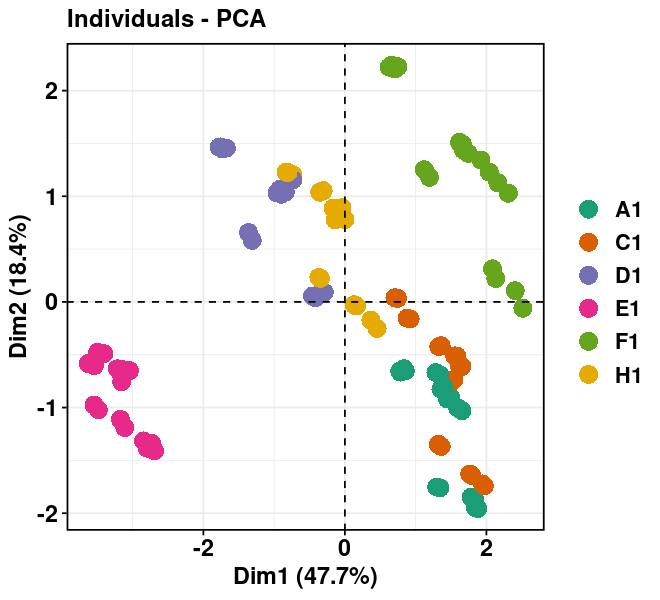

In [32]:
options(repr.plot.width=5.5, repr.plot.height=5)

fviz_pca_ind(pca,habillage=allMatrix$Participant, geom="point", repel = TRUE, labelsize = 3, pointsize = 5,
             palette = c("#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02"),         
             invisible="quali") +
     scale_shape_manual(values=c(16, 16, 16, 16, 16, 16))+
     theme(panel.border = element_rect(colour = "black", fill=NA, size=1),
            text = element_text(size = 12, face = "bold", colour = "black"),
            axis.title = element_text(size = 14, face = "bold", colour = "black"),
            axis.text = element_text(size = 14, face = "bold", colour = "black"),
            #legend.position="bottom", legend.box="vertical", legend.margin=margin(), 
            legend.title=element_blank(),
            legend.key.size = unit(0.7, 'cm'),
            legend.text=element_text(size=13, face = "bold", colour = "black")) +
            guides(color = guide_legend(override.aes = list(size = 5)))
